In [1]:
#============================================================================
# Copyright (c) 2018 Nghia T. Vo. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#============================================================================
# Author: Nghia T. Vo
# E-mail: nghia.vo@diamond.ac.uk
# Description: Original implementation of stripe artifact removal methods, 
# Nghia T. Vo, Robert C. Atwood, and Michael Drakopoulos, "Superior
# techniques for eliminating ring artifacts in X-ray micro-tomography," Optics
# Express 26, 28396-28412 (2018).
# https://doi.org/10.1364/OE.26.028396
# Publication date: 18th October 2018
#============================================================================

In [2]:
import numpy as np
from scipy.ndimage import median_filter
from scipy import signal
#from scipy.fftpack import fft, ifft, fft2, ifft2
import pyfftw.interfaces.scipy_fftpack as fft
from scipy.signal import savgol_filter
from scipy.ndimage import binary_dilation
from scipy.ndimage import uniform_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
def remove_stripe_based_sorting(sinogram, size):
    """
    Algorithm 3 in the paper. Remove stripes using the sorting technique.
    Work particularly well for removing partial stripes.
    Angular direction is along the axis 0
    ---------
    Parameters: - sinogram: 2D array. 
                - size: window size of the median filter.
    ---------
    Return:     - stripe-removed sinogram.
    """
    sinogram = np.transpose(sinogram)
    (nrow, ncol) = sinogram.shape
    listindex = np.arange(0.0, ncol, 1.0)
    matindex = np.tile(listindex,(nrow,1))
    matcomb = np.asarray(np.dstack((matindex, sinogram)))
    matsort = np.asarray(
        [row[row[:, 1].argsort()] for row in matcomb])
    matsort[:, :, 1] = median_filter(matsort[:, :, 1],(size,1))
    matsortback = np.asarray(
        [row[row[:, 0].argsort()] for row in matsort])
    sino_corrected = matsortback[:, :, 1]
    return np.transpose(sino_corrected)

In [4]:
def remove_stripe_based_filtering(sinogram, sigma, size):
    """
    Algorithm 2 in the paper. Remove stripes using the filtering technique.
    Angular direction is along the axis 0
    ---------
    Parameters: - sinogram: 2D array.
                - sigma: sigma of the Gaussian window which is used to separate 
                        the low-pass and high-pass components of the intensity
                        profiles of each column.
                - size: window size of the median filter.
    ---------
    Return:     - stripe-removed sinogram.
    """
    pad = 150 # To reduce artifacts caused by FFT
    sinogram = np.transpose(sinogram)
    sinogram2 = np.pad(sinogram,((0, 0),(pad, pad)), mode = 'reflect')
    (_, ncol) = sinogram2.shape
    window = signal.gaussian(ncol, std = sigma)
    listsign = np.power(-1.0,np.arange(ncol))
    sinosmooth = np.zeros_like(sinogram)
    for i,sinolist in enumerate(sinogram2):
        #sinosmooth[i] = np.real(ifft(fft(sinolist*listsign)*window)*listsign)[pad:ncol-pad]
        sinosmooth[i] = np.real(fft.ifft(fft.fft(sinolist*listsign)*window)*listsign)[pad:ncol-pad]
    sinosharp = sinogram - sinosmooth
    sinosmooth_cor = median_filter(sinosmooth,(size,1))
    return np.transpose(sinosmooth_cor + sinosharp)

In [5]:
def _2d_window_ellipse(height, width, sigmax, sigmay):
    """
    Create a 2D Gaussian window.
    ---------
    Parameters: - height, width: shape of the window.
                - sigmax, sigmay: sigmas of the window.
    ---------
    Return:     - 2D window.
    """
    centerx = (width-1.0)/2.0
    centery = (height-1.0)/2.0    
    y,x = np.ogrid[-centery:height-centery,-centerx:width-centerx]
    numx = 2.0*sigmax*sigmax
    numy = 2.0*sigmay*sigmay
    win2d = np.exp(-(x*x/numx+y*y/numy))
    return win2d

In [6]:
def _2d_filter(mat, sigmax, sigmay, pad):
    """
    Filtering an image using 2D Gaussian window.
    ---------
    Parameters: - mat: 2D array.
                - sigmax, sigmay: sigmas of the window.
                - pad: padding for FFT
    ---------
    Return:     - filtered image.
    """
    matpad = np.pad(mat,((0, 0), (pad, pad)), mode = 'edge')
    matpad = np.pad(matpad,((pad, pad), (0, 0)), mode = 'mean')
    (nrow, ncol) = matpad.shape
    win2d = _2d_window_ellipse(nrow, ncol, sigmax, sigmay)
    listx = np.arange(0, ncol)
    listy = np.arange(0, nrow)
    x,y = np.meshgrid(listx, listy)
    matsign = np.power(-1.0,x+y)
    #matfilter = np.real(ifft2(fft2(matpad*matsign)*win2d)*matsign)
    matfilter = np.real(fft.ifft2(fft.fft2(matpad*matsign)*win2d)*matsign)
    return matfilter[pad:nrow-pad,pad:ncol-pad]

In [7]:
def remove_stripe_based_fitting(sinogram, order, sigmax, sigmay):
    """
    Algorithm 1 in the paper. Remove stripes using the fitting technique.
    Angular direction is along the axis 0
    ---------
    Parameters: - sinogram: 2D array.
                - order: polynomical fit order.
                - sigmax, sigmay: sigmas of the Gaussian window.
    ---------
    Return:     - stripe-removed sinogram.
    """
    (nrow, _) = sinogram.shape
    nrow1 = nrow
    if nrow1%2==0:
        nrow1 = nrow1 - 1
    sinofit = savgol_filter(sinogram, nrow1, order, axis=0,mode = 'mirror')
    sinofitsmooth = _2d_filter(sinofit, sigmax, sigmay, 50)
    num1 = np.mean(sinofit)
    num2 = np.mean(sinofitsmooth)
    sinofitsmooth = num1*sinofitsmooth/num2
    return sinogram/sinofit*sinofitsmooth

In [8]:
def detect_stripe(listdata, snr):
    """
    Algorithm 4 in the paper. Used to locate stripe positions.
    ---------
    Parameters: - listdata: 1D normalized array.
                - snr: ratio used to discriminate between useful
                    information and noise.
    ---------
    Return:     - 1D binary mask.
    """
    numdata = len(listdata)
    listsorted = np.sort(listdata)[::-1]
    xlist = np.arange(0, numdata, 1.0)
    ndrop = np.int16(0.25 * numdata)
    (_slope, _intercept) = np.polyfit(
        xlist[ndrop:-ndrop-1], listsorted[ndrop:-ndrop - 1], 1)
    numt1 = _intercept + _slope * xlist[-1]
    noiselevel = np.abs(numt1 - _intercept)
    val1 = np.abs(listsorted[0] - _intercept) / noiselevel
    val2 = np.abs(listsorted[-1] - numt1) / noiselevel
    listmask = np.zeros_like(listdata)
    if (val1 >= snr):
        upper_thresh = _intercept + noiselevel * snr * 0.5
        listmask[listdata > upper_thresh] = 1.0
    if (val2 >= snr):
        lower_thresh = numt1 - noiselevel * snr * 0.5
        listmask[listdata <= lower_thresh] = 1.0
    return listmask

In [9]:
def remove_large_stripe(sinogram, snr, size):
    """
    Algorithm 5 in the paper. Remove large stripes by: locating stripes,
    normalizing to remove full stripes, using the sorting technique to
    remove partial stripes.
    Angular direction is along the axis 0.
    ---------
    Parameters: - sinogram: 2D array.
                - snr: ratio used to discriminate between useful
                    information and noise.
                - size: window size of the median filter.
    ---------
    Return:     - stripe-removed sinogram.
    """
    badpixelratio = 0.05
    (nrow, ncol) = sinogram.shape
    ndrop = np.int16(badpixelratio * nrow)
    sinosorted = np.sort(sinogram, axis=0)
    sinosmoothed = median_filter(sinosorted, (1, size))
    list1 = np.mean(sinosorted[ndrop:nrow - ndrop], axis=0)
    list2 = np.mean(sinosmoothed[ndrop:nrow - ndrop], axis=0)
    listfact = list1 / list2
    listmask = detect_stripe(listfact, snr)
    listmask = binary_dilation(listmask, iterations=1).astype(listmask.dtype)
    matfact = np.tile(listfact,(nrow,1))
    sinogram = sinogram / matfact
    sinogram1 = np.transpose(sinogram)
    listindex = np.arange(0.0, nrow, 1.0)
    matindex = np.tile(listindex,(ncol,1))
    matcombine = np.asarray(np.dstack((matindex, sinogram1)))
    matsort = np.asarray(
        [row[row[:, 1].argsort()] for row in matcombine])
    matsort[:, :, 1] = np.transpose(sinosmoothed)
    matsortback = np.asarray(
        [row[row[:, 0].argsort()] for row in matsort])
    sino_corrected = np.transpose(matsortback[:, :, 1])
    listxmiss = np.where(listmask > 0.0)[0]
    sinogram[:, listxmiss] = sino_corrected[:, listxmiss]
    return sinogram

In [10]:
def remove_unresponsive_and_fluctuating_stripe(sinogram, snr, size):
    """
    Algorithm 6 in the paper. Remove unresponsive or fluctuating stripes by:
    locating stripes, correcting by interpolation.
    Angular direction is along the axis 0.
    ---------
    Parameters: - sinogram: 2D array.
                - snr: ratio used to discriminate between useful
                    information and noise
                - size: window size of the median filter.
    ---------
    Return:     - stripe-removed sinogram.
    """
    sinogram = np.copy(sinogram) # Make it mutable
    (nrow, _) = sinogram.shape
    sinosmoothed = np.apply_along_axis(uniform_filter1d, 0, sinogram, 10)
    listdiff = np.sum(np.abs(sinogram - sinosmoothed), axis=0)
    nmean = np.mean(listdiff)
    listdiffbck = median_filter(listdiff, size)
    listdiffbck[listdiffbck == 0.0] = nmean
    listfact = listdiff / listdiffbck
    listmask = detect_stripe(listfact, snr)
    listmask = binary_dilation(listmask, iterations=1).astype(listmask.dtype)
    listmask[0:2] = 0.0
    listmask[-2:] = 0.0
    listx = np.where(listmask < 1.0)[0]
    listy = np.arange(nrow)
    matz = sinogram[:, listx]
    finter = interpolate.interp2d(listx, listy, matz, kind='linear')
    listxmiss = np.where(listmask > 0.0)[0]
    if len(listxmiss) > 0:
        matzmiss = finter(listxmiss, listy)
        sinogram[:, listxmiss] = matzmiss
    # Use algorithm 5 to remove residual stripes
    #sinogram = remove_large_stripe(sinogram, snr, size) 
    return sinogram

In [11]:
def remove_all_stripe(sinogram, snr, la_size, sm_size):
    """
    Remove all types of stripe artifacts by combining algorithm 6, 5, and 3.
    Angular direction is along the axis 0.
    ---------
    Parameters: - sinogram: 2D array.
                - snr: ratio used to discriminate between useful
                    information and noise
                - la_size: window size of the median filter to remove
                    large stripes.
                - sm_size: window size of the median filter to remove
                    small-to-medium stripes.
    ---------
    Return:     - stripe-removed sinogram.
    """
    sinogram = remove_unresponsive_and_fluctuating_stripe(sinogram, snr, la_size)
    sinogram = remove_large_stripe(sinogram, snr, la_size)
    sinogram = remove_stripe_based_sorting(sinogram, sm_size)
    return sinogram

In [12]:
# ----------------------------------------------------------------------------
# Example of use:
# sinogram = remove_stripe_based_sorting(sinogram, 31)
# sinogram = remove_stripe_based_filtering(sinogram, 3, 31)
# sinogram = remove_stripe_based_fitting(sinogram, 1, 5, 20)
# sinogram = remove_unresponsive_and_fluctuating_stripe(sinogram1, 3, 81)
# sinogram = remove_large_stripe(sinogram1, 3, 81)
# sinogram = remove_all_stripe(sinogram, 3, 81, 31)

# Playground

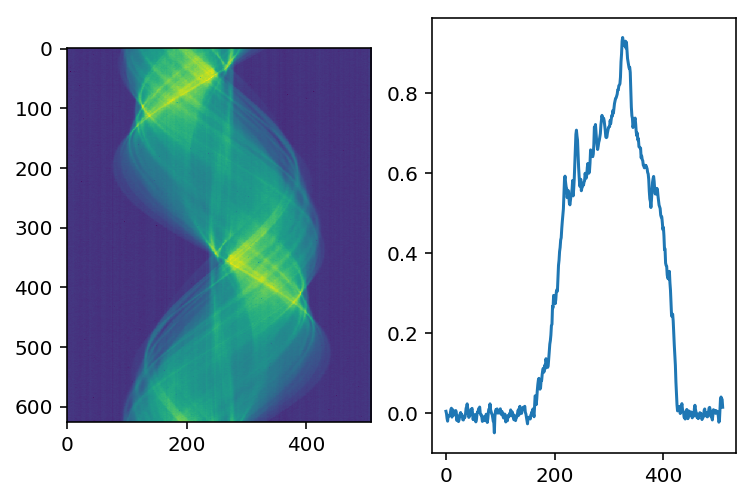

In [13]:
sino = io.imread('../../UnitTests/data/woodsino_0100.tif')
plt.subplot(1,2,1)
plt.imshow(sino)
plt.subplot(1,2,2)
plt.plot(sino[300,:])

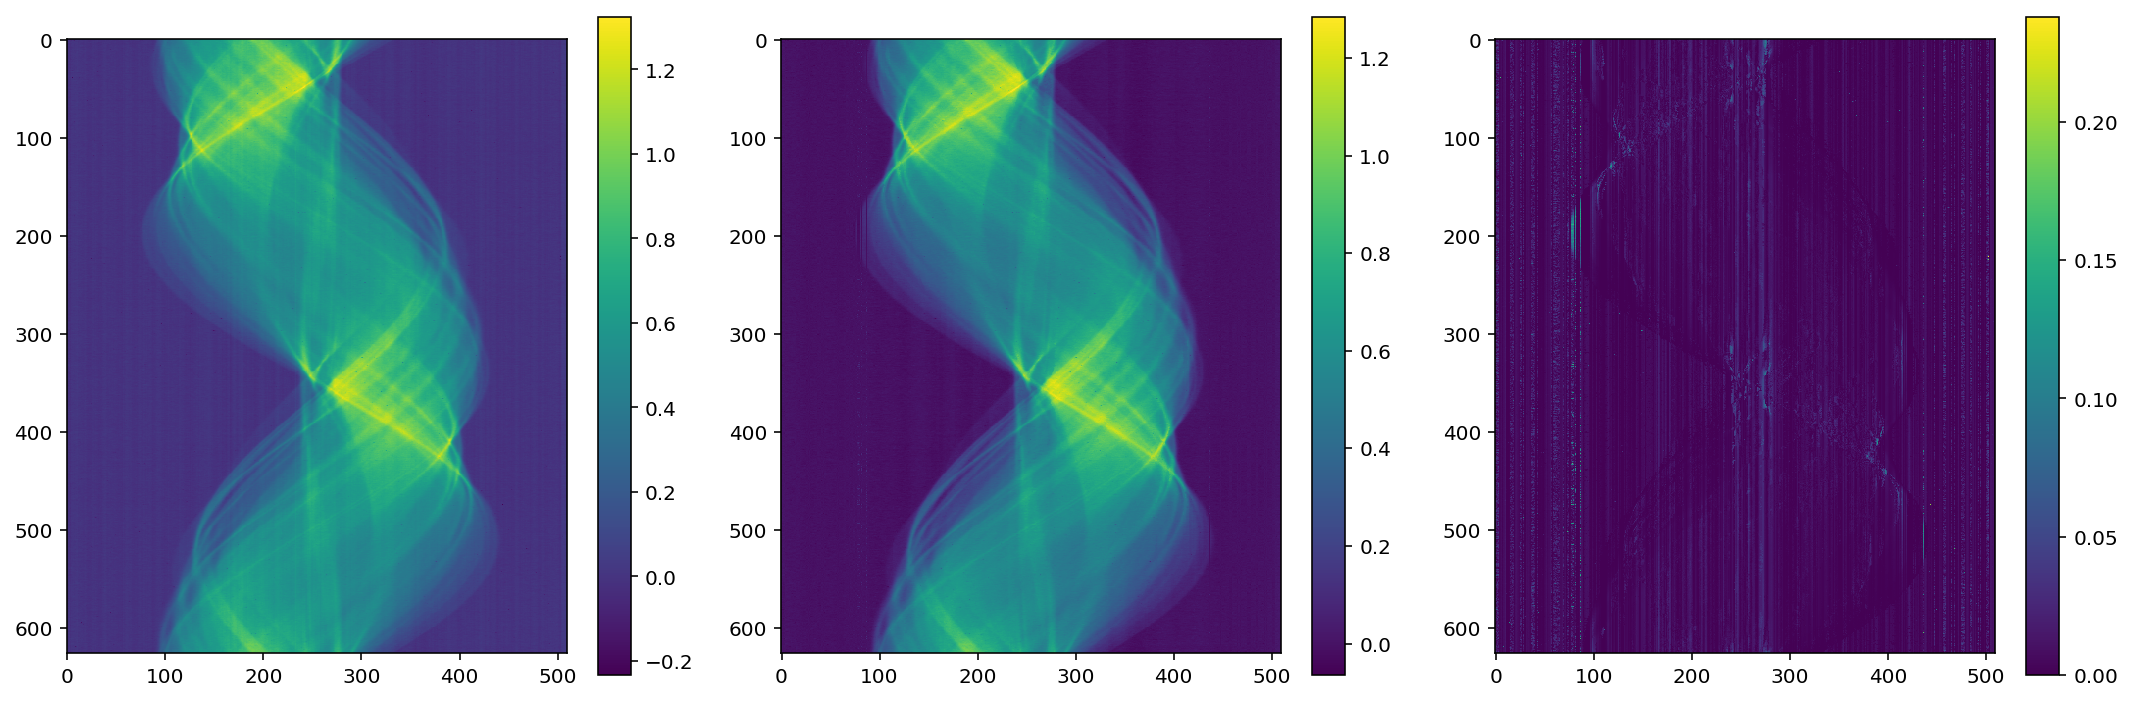

In [14]:
cleansino = remove_all_stripe(sino, 5, 21, 11)
#cleansino = remove_all_stripe(sino,3, 81, 31)
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(sino)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(cleansino)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.abs(sino-cleansino))
plt.colorbar()
plt.tight_layout()

In [15]:
import tomopy
import dxchange

In [16]:
fname = '/data/tomopy/tooth.h5'
start = 0
end = 2
proj, flat, dark, theta = dxchange.read_aps_32id(fname, sino=(start, end))

OSError: Unable to open file (unable to open file: name = '/data/tomopy/tooth.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
plt.imshow(proj[:, 0, :], cmap='Greys_r')
plt.show()
print(proj.shape)

In [ ]:
if (theta is None):
    theta = tomopy.angles(proj.shape[0])
else:
    pass

In [ ]:
proj = tomopy.normalize(proj, flat, dark)
proj = tomopy.minus_log(proj)

In [ ]:
rot_center = tomopy.find_center(proj, theta, init=290, ind=0, tol=0.5)
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec')
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

In [ ]:
plt.imshow(recon[0, :,:], cmap='Greys_r')
plt.show()

# My data

In [ ]:
s2=sino.reshape(sino.shape[0],1,sino.shape[1])
print(s2.shape)
theta = tomopy.angles(s2.shape[0],ang1=0,ang2=360)

In [ ]:
rot_center = tomopy.find_center(s2,theta,init = 290, ind = 0, tol=0.5)
print(rot_center)

In [ ]:
rec       = tomopy.recon(s2, theta, center=rot_center, algorithm='gridrec')
rec       = tomopy.circ_mask(rec, axis=0, ratio=0.95)
rec_clean = tomopy.recon(cleansino.reshape(sino.shape[0],1,sino.shape[1]), theta, center=rot_center, algorithm='gridrec')
rec_clean = tomopy.circ_mask(rec_clean, axis=0, ratio=0.95)
plt.figure(figsize=[15,15])
plt.subplot(2,2,1)
plt.imshow(rec[0,:,:],vmin=-0.01, vmax=0.025)
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(rec_clean[0,:,:],vmin=-0.01, vmax=0.025)
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(rec[0,:,:]-rec_clean[0,:,:])
plt.tight_layout()